In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
from tqdm.auto import tqdm
import itertools
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})

#### Set choices

USPS is among: 
```
print(sorted(census_tracts['USPS'].unique()))
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
```
    

In [72]:
#filterUSPS = ['CA']
filterUSPS = ['MD', 'DC', 'VA', 'DE', 'PA', 'NJ']
#filterUSPS = ['CA', 'OR', 'WA']
foldername = 'around-maryland/'
#foldername = 'east-coast/'

In [73]:
commute_data = pd.read_csv('data/united-states-commutes/commute_data.csv')
census_tracts = pd.read_csv('data/united-states-commutes/census_tracts_2010.csv')

census_tracts = census_tracts[census_tracts['USPS'].isin(filterUSPS)]
commute_data = commute_data[commute_data['OFIPS'].isin(census_tracts['GEOID'].unique())]
commute_data = commute_data[commute_data['DFIPS'].isin(census_tracts['GEOID'].unique())]
census_tracts = census_tracts.sort_values('POP10', ascending=True)
census_tracts.reset_index(inplace=True)
commute_data.reset_index(inplace=True)

From readme:

    - Ofips - the full FIPS code for the origin census tract of an individual flow line
    - Dfips  - the full FIPS code for the destination census tract of an individual flow line
    - Ostfips - the FIPS code for the origin state of an individual flow line
    - Octfips - the FIPS code for the origin county of an individual flow line
    - Otrfips - the FIPS code for the origin census tract of an individual flow line
    - Dstfips - the FIPS code for the destination state of an individual flow line
    - Dctfips - the FIPS code for the destination county of an individual flow line
    - Dtrfips - the FIPS code for the destination census tract of an individual flow line
    - Flow - the total number of commuters associated with this individual point to point flow line (i.e. the total number of journeys to work)
    - Moe - margin of error of the Flow value above
    - LenKM - length of each flow line, in Kilometers
    - ESTDIVMOE - the Flow value divided by the Margin of Error of the estimate 

In [66]:
commute_data.head()

,index,OFIPS,DFIPS,OSTFIPS,OCTFIPS,OTRFIPS,DSTFIPS,DCTFIPS,DTRFIPS,FLOW,MOE,LENKM,ESTDIVMOE
0,0,6073018700,6073018700,6,73,18700,6,73,18700,20950,2359,0.0,8.88
1,4,6071010402,6071010402,6,71,10402,6,71,10402,7040,848,0.0,8.30
2,22,6073009400,6073009400,6,73,9400,6,73,9400,3325,618,0.0,5.38
3,23,6059062614,6059062614,6,59,62614,6,59,62614,3275,1235,0.0,2.65
4,24,6073006300,6073006300,6,73,6300,6,73,6300,3125,755,0.0,4.14


from https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/gaz10-record-layouts.html

    USPS	United States Postal Service State Abbreviation
    GEOID	Geographic Identifier - fully concatenated geographic code (State FIPS and district number)
    POP10	2010 Census population count.
    HU10	2010 Census housing unit count.
    ALAND	Land Area(square meters) - Created for statistical purposes only.
    AWATER	Water Area (square meters) - Created for statistical purposes only.
    ALAND_SQMI	Land Area (square miles) - Created for statistical purposes only.
    AWATER_SQMI	Water Area (square miles) - Created for statistical purposes only.
    INTPTLAT	Latitude (decimal degrees) First character is blank or "-" denoting North or South latitude respectively.
    INTPTLONG	Longitude (decimal degrees) First character is blank or "-" denoting East or West longitude respectively.

In [74]:
census_tracts.head()

,index,USPS,GEOID,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,30266,MD,24017990000,0,0,0,361416437,0.000,139.544,38.375937,-77.084185
1,68708,VA,51153980100,0,1,84755286,220247,32.724,0.085,38.592179,-77.472494
2,68396,VA,51087980100,0,0,8824928,46527,3.407,0.018,37.504783,-77.320899
3,30907,MD,24035990000,0,0,0,85637070,0.000,33.065,38.994389,-76.342775
4,30908,MD,24035990100,0,0,0,125853276,0.000,48.592,38.867541,-76.321270


In [75]:
attribution = np.empty(len(census_tracts))
attribution[:] = np.nan
for index, row in tqdm(census_tracts.iterrows(), total=census_tracts.shape[0]):
            attribution[index] = int(str(row['GEOID'])[:4])
census_tracts['METROP'] = attribution
counties_names = np.unique(attribution)
n_counties = len(counties_names)

pop = np.zeros(n_counties)
state_USPS = []
for i, ct in enumerate(counties_names):
    pop[i] = census_tracts[census_tracts['METROP'] == ct]['POP10'].sum()
    state_USPS.append(census_tracts[census_tracts['METROP'] == ct].USPS.iloc[0])
    
groups = {'geoid' : counties_names,
          'pop2010' : pop,
          'stateUSPS':state_USPS }
california_data = pd.DataFrame.from_dict(groups)

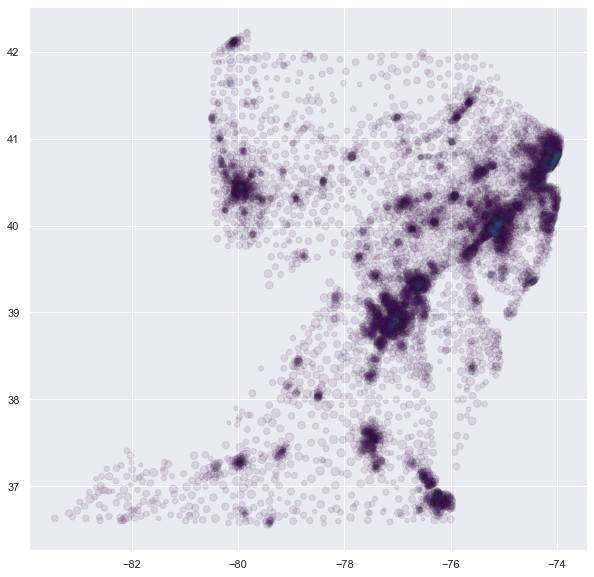

In [76]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(census_tracts['INTPTLONG'], census_tracts['INTPTLAT'], s =census_tracts['POP10']/100,
           edgecolors = 'k', c =census_tracts['POP10']/census_tracts['ALAND']*1e5, 
           cmap='viridis', alpha = .1)

In [47]:
# Augment commute data with our newly specified metrop:
ori_attr = np.empty(len(commute_data))
dest_attr = np.empty(len(commute_data))
ori_attr[:] = np.nan
dest_attr[:] = np.nan
for index, row in tqdm(commute_data.iterrows(), total=commute_data.shape[0]):
   
    ori_attr[index] =   census_tracts[census_tracts['GEOID'] == row['OFIPS']]['METROP']
    dest_attr[index] =  census_tracts[census_tracts['GEOID'] == row['DFIPS']]['METROP']

commute_data['OMETROP'] = ori_attr
commute_data['DMETROP'] = dest_attr

In [48]:
mobility = np.zeros((n_counties, n_counties))
for ori_i, ori_v in tqdm(enumerate(counties_names), total = len(counties_names)):
    for dest_i, dest_v in enumerate(counties_names):
        mobility[ori_i][dest_i] = commute_data[(commute_data['OMETROP'] == ori_v) & (commute_data['DMETROP'] == dest_v)]['FLOW'].sum()

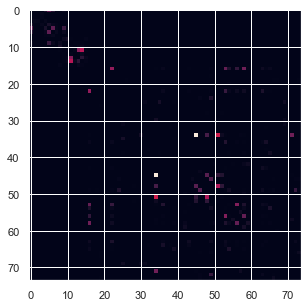

In [49]:
np.fill_diagonal(mobility,0)
mobility = mobility + mobility.T # Symetric mobility doubling fluxes mobility.sum is around 5M which is a bit low
plt.imshow(mobility)

In [78]:
np.savetxt(f'data/{foldername}mobility.txt', mobility)
california_data.to_csv(f'data/{foldername}geodata.csv', index_label='id')